In [26]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import random

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

In [27]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# DEVICE
# --------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [28]:
train_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.Resize((320, 320)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

eval_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# LOAD DATA FROM CSV
def load_split_from_csv(split, transform):

    csv_file = f"{split}_data.csv"
    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV not found for split '{split}': {csv_file}")

    df = pd.read_csv(csv_file)

    if "image_filename" not in df.columns or "has_person" not in df.columns:
        raise ValueError("CSV must contain 'image_filename' and 'has_person'")

    images_dir = os.path.join("data", split, "images")

    X_list = []
    y_list = []

    for _, row in df.iterrows():
        img_name = row["image_filename"]
        label = int(row["has_person"])

        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Warning: image not found, skipping: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img)

        X_list.append(img_tensor)
        y_list.append(label)

    X = torch.stack(X_list)
    y = torch.tensor(y_list, dtype=torch.long)

    print(f"{split.capitalize()} loaded: X shape = {X.shape}, y shape = {y.shape}")
    return X, y

# ---------------------------------------------------
# LOAD ALL SPLITS
BATCH_SIZE = 16

# Augment only training set
X_train, y_train = load_split_from_csv("train", transform=train_transform)

# DO NOT augment eval splits
X_valid, y_valid = load_split_from_csv("valid", transform=eval_transform)
X_test,  y_test  = load_split_from_csv("test",  transform=eval_transform)



class_counts = torch.bincount(y_train)   # tensor([num_no_person, num_person])
print("class_counts:", class_counts)

# Inverse-frequency weights (more weight to the minority class 0)
class_weights = 1.0 / class_counts.float()

# Optional: normalize so weights sum to number of classes (2.0 here)
class_weights = class_weights / class_weights.sum() * 2.0

print("class_weights:", class_weights)

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ---------------------------------------------------

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    TensorDataset(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False
)
# ---------------------------------------------------

# Check if the images are correctly loaded
def show_image_from_tensor(split, idx):
    """
    Show image and label from the already-loaded tensors
    instead of re-reading CSV or disk again.
    """
    if split == "train":
        X, y = X_train, y_train
    elif split == "valid":
        X, y = X_valid, y_valid
    elif split == "test":
        X, y = X_test, y_test
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")

    if idx < 0 or idx >= len(X):
        raise IndexError(f"Index {idx} out of range for split '{split}'")

    img_tensor = X[idx]  # [3, 224, 224]
    label = y[idx].item()

    # unnormalize for display
    img_np = img_tensor.numpy().transpose(1, 2, 0)
    img_np = (img_np * 0.5) + 0.5  # reverse normalization
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)
    plt.title(f"[{split}] idx={idx}, has_person={label}")
    plt.axis("off")
    plt.show()

Train loaded: X shape = torch.Size([4041, 3, 320, 320]), y shape = torch.Size([4041])
Valid loaded: X shape = torch.Size([1144, 3, 320, 320]), y shape = torch.Size([1144])
Test loaded: X shape = torch.Size([570, 3, 320, 320]), y shape = torch.Size([570])
class_counts: tensor([ 571, 3470])
class_weights: tensor([1.7174, 0.2826])


Train label counts: tensor([ 571, 3470])
Valid label counts: tensor([177, 967])
Test  label counts: tensor([ 84, 486])


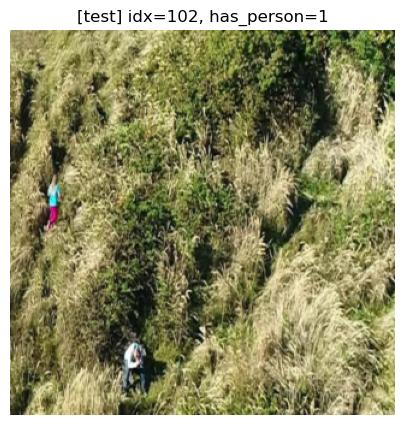

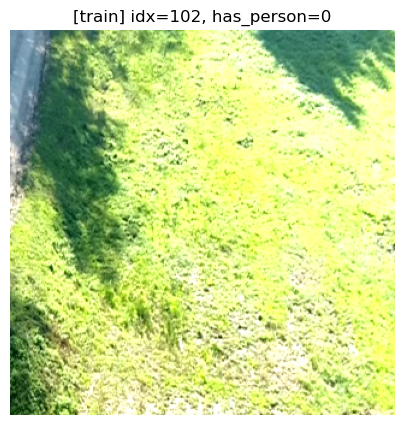

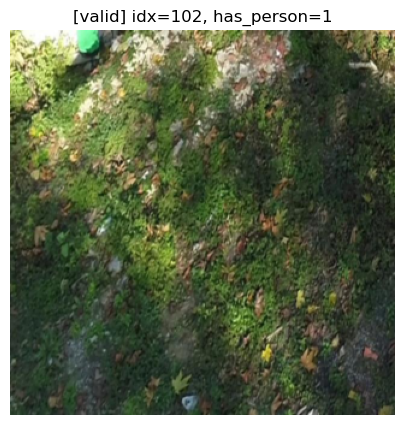

In [29]:
print("Train label counts:", torch.bincount(y_train))
print("Valid label counts:", torch.bincount(y_valid))
print("Test  label counts:", torch.bincount(y_test))

show_image_from_tensor("test", 102)
show_image_from_tensor("train", 102)
show_image_from_tensor("valid", 102)

In [30]:
# TRAINING UTILITIES
# --------------------
def compute_correct_labels(outputs, labels):
    """
    outputs: [B, 2] logits
    labels:  [B]    (0 or 1)
    """
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct, total

def training_loop(model, optimizer, num_epochs, train_loader, test_loader, device, printing=True):

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):

        # ----- TRAIN -----
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0

        for train_inputs, train_labels in train_loader:
            train_inputs = train_inputs.to(device)
            train_labels = train_labels.to(device)

            optimizer.zero_grad()
            outputs = model(train_inputs)

            # accuracy
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total

            # loss
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ----- EVAL (on test/valid loader) -----
        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)

                outputs = model(test_inputs)

                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total

                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(
                f"Epoch {epoch+1}/{num_epochs} "
                f"- Train Loss: {avg_train_loss:.4f}, "
                f"Train Acc: {total_train_correct}/{total_train_images} "
                f"- Eval Loss: {avg_test_loss:.4f}, "
                f"Eval Acc: {total_test_correct}/{total_test_images}"
            )

    return train_losses, test_losses

In [31]:
def create_resnet18_model(num_classes=2, freeze_backbone=False):
    # Load pretrained ResNet-18
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Optionally freeze backbone
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Replace final FC layer to output 2 classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

In [32]:
# INIT + TRAIN
# --------------------
model = create_resnet18_model(num_classes=2, freeze_backbone=False).to(device)

# Slightly smaller LR is usually better for finetuning pretrained nets
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

NUM_EPOCHS = 10  # start with 5 just to see if things work

# Use train_loader for training, valid_loader (or test_loader) for evaluation
train_losses, eval_losses = training_loop(
    model=model,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    test_loader=valid_loader,   # or test_loader if you prefer
    device=device,
    printing=True
)

Epoch 1/10 - Train Loss: 0.4026, Train Acc: 3271/4041 - Eval Loss: 0.3163, Eval Acc: 1000/1144
Epoch 2/10 - Train Loss: 0.1940, Train Acc: 3689/4041 - Eval Loss: 0.2677, Eval Acc: 1046/1144
Epoch 3/10 - Train Loss: 0.1097, Train Acc: 3844/4041 - Eval Loss: 0.3663, Eval Acc: 1062/1144
Epoch 4/10 - Train Loss: 0.0549, Train Acc: 3964/4041 - Eval Loss: 0.4724, Eval Acc: 1065/1144
Epoch 5/10 - Train Loss: 0.0663, Train Acc: 3941/4041 - Eval Loss: 0.3505, Eval Acc: 1057/1144
Epoch 6/10 - Train Loss: 0.0555, Train Acc: 3967/4041 - Eval Loss: 0.3920, Eval Acc: 1057/1144
Epoch 7/10 - Train Loss: 0.0617, Train Acc: 3952/4041 - Eval Loss: 0.3941, Eval Acc: 1053/1144
Epoch 8/10 - Train Loss: 0.0430, Train Acc: 3985/4041 - Eval Loss: 0.4305, Eval Acc: 965/1144
Epoch 9/10 - Train Loss: 0.0374, Train Acc: 3989/4041 - Eval Loss: 0.3035, Eval Acc: 1060/1144
Epoch 10/10 - Train Loss: 0.0226, Train Acc: 4007/4041 - Eval Loss: 0.5068, Eval Acc: 1071/1144


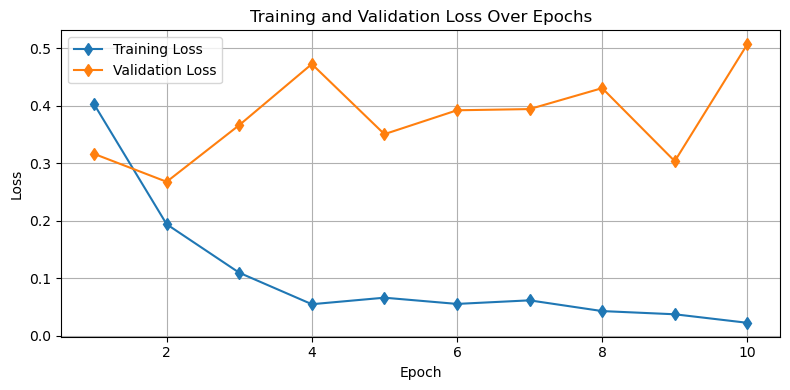

In [33]:
# PLOT LOSSES
# --------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), eval_losses, 'd-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
def count_predictions(model, loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)               # logits [B, 2]
            _, preds = torch.max(outputs, 1)    # predicted class index

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    print("\n========== Prediction Counts ==========")
    print("Predicted 0 (no human):", np.sum(all_preds == 0))
    print("Predicted 1 (human):    ", np.sum(all_preds == 1))

    print("\n========== True Label Counts ==========")
    print("True 0 (no human):", np.sum(all_labels == 0))
    print("True 1 (human):   ", np.sum(all_labels == 1))

    return all_preds, all_labels


In [35]:
preds, labels = count_predictions(model, train_loader, device)


========== Prediction Counts ==========
Predicted 0 (no human): 580
Predicted 1 (human):     3461

========== True Label Counts ==========
True 0 (no human): 571
True 1 (human):    3470


In [36]:
def evaluate_on_loader(model, loader, device, loader_name="test"):
    """
    Evaluates the model on a given DataLoader and prints:
      - average loss
      - accuracy
      - predicted counts per class
      - true label counts per class
      - 2x2 confusion matrix (for binary 0/1)
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)                # [B, 2] logits
            loss = criterion(outputs, labels)

            # accumulate loss
            total_loss += loss.item()

            # predictions
            _, preds = torch.max(outputs, dim=1)

            # accuracy
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # store for counts & confusion matrix
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # counts
    pred_0 = np.sum(all_preds == 0)
    pred_1 = np.sum(all_preds == 1)
    true_0 = np.sum(all_labels == 0)
    true_1 = np.sum(all_labels == 1)

    # confusion matrix for binary classes 0/1
    # rows = true, cols = predicted
    # [ [TN, FP],
    #   [FN, TP] ]
    TN = np.sum((all_labels == 0) & (all_preds == 0))
    FP = np.sum((all_labels == 0) & (all_preds == 1))
    FN = np.sum((all_labels == 1) & (all_preds == 0))
    TP = np.sum((all_labels == 1) & (all_preds == 1))

    print("\n========== Evaluation on", loader_name, "set ==========")
    print(f"Avg loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy*100:.2f}% ({total_correct}/{total_samples})")

    print("\nPredicted class counts:")
    print(f"  Pred 0 (no human): {pred_0}")
    print(f"  Pred 1 (human):    {pred_1}")

    print("\nTrue label counts:")
    print(f"  True 0 (no human): {true_0}")
    print(f"  True 1 (human):    {true_1}")

    print("\nConfusion matrix (rows=true, cols=pred):")
    print("          Pred 0    Pred 1")
    print(f"True 0 |   {TN:4d}     {FP:4d}")
    print(f"True 1 |   {FN:4d}     {TP:4d}")

    return {
        "avg_loss": avg_loss,
        "accuracy": accuracy,
        "preds": all_preds,
        "labels": all_labels,
        "confusion": np.array([[TN, FP],
                               [FN, TP]])
    }


In [37]:
results = evaluate_on_loader(model, test_loader, device, loader_name="test")


========== Evaluation on test set ==========
Avg loss: 0.1572
Accuracy: 95.09% (542/570)

Predicted class counts:
  Pred 0 (no human): 88
  Pred 1 (human):    482

True label counts:
  True 0 (no human): 84
  True 1 (human):    486

Confusion matrix (rows=true, cols=pred):
          Pred 0    Pred 1
True 0 |     72       12
True 1 |     16      470


* The model is predicting human all the time, as samples have more human images, it producing fake high results
* Need to add weights for non-human,
* there is a data imbalance between human and non-human images
* we can add some data-augmentation to make more non_human images

In [38]:
def show_predictions_grid(model, loader, device, num_images=8):
    """
    Randomly selects 'num_images' images from the loader,
    shows the image, prediction, and true label in a grid.
    """

    model.eval()

    all_imgs = []
    all_preds = []
    all_labels = []

    # --- Pass through loader once & store everything ---
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for i in range(imgs.size(0)):
                all_imgs.append(imgs[i].cpu())
                all_preds.append(preds[i].item())
                all_labels.append(labels[i].item())

    total = len(all_imgs)
    if total == 0:
        print("Loader contains no images.")
        return

    # --- Choose random indices ---
    indices = random.sample(range(total), num_images)

    # --- Display chosen images ---
    cols = 4
    #rows = num_images // cols
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(16, 8))

    for plot_i, idx in enumerate(indices):
        img = all_imgs[idx]
        pred = all_preds[idx]
        true = all_labels[idx]

        # Unnormalize
        img_np = img.numpy().transpose(1, 2, 0)
        img_np = (img_np * 0.5) + 0.5  # inverse of Normalize(0.5, 0.5)
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(rows, cols, plot_i + 1)
        plt.imshow(img_np)
        plt.axis("off")

        title_color = "green" if pred == true else "red"
        plt.title(f"Pred: {pred} | True: {true}", color=title_color)

    plt.tight_layout()
    plt.show()

In [39]:
def load_folder_as_loader(folder_path, transform, batch_size=32, label_value=1):

    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f"Folder not found: {folder_path}")

    img_filenames = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    ]

    if len(img_filenames) == 0:
        raise ValueError(f"No image files found in folder: {folder_path}")

    img_filenames.sort()  # optional, just to have a consistent order

    X_list = []
    y_list = []

    for fname in img_filenames:
        img_path = os.path.join(folder_path, fname)

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Warning: could not open {img_path}: {e}")
            continue

        img_tensor = transform(img)
        X_list.append(img_tensor)
        y_list.append(label_value)

    if len(X_list) == 0:
        raise ValueError(f"No valid images loaded from folder: {folder_path}")

    X = torch.stack(X_list)
    y = torch.tensor(y_list, dtype=torch.long)

    print(f"Extra folder '{folder_path}' loaded: X shape = {X.shape}, y shape = {y.shape}")
    print(f"All labels are set to {label_value} (has_person).")

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return loader


Extra folder 'pp' loaded: X shape = torch.Size([21, 3, 320, 320]), y shape = torch.Size([21])
All labels are set to 1 (has_person).

========== Evaluation on pp set ==========
Avg loss: 0.2220
Accuracy: 85.71% (18/21)

Predicted class counts:
  Pred 0 (no human): 3
  Pred 1 (human):    18

True label counts:
  True 0 (no human): 0
  True 1 (human):    21

Confusion matrix (rows=true, cols=pred):
          Pred 0    Pred 1
True 0 |      0        0
True 1 |      3       18


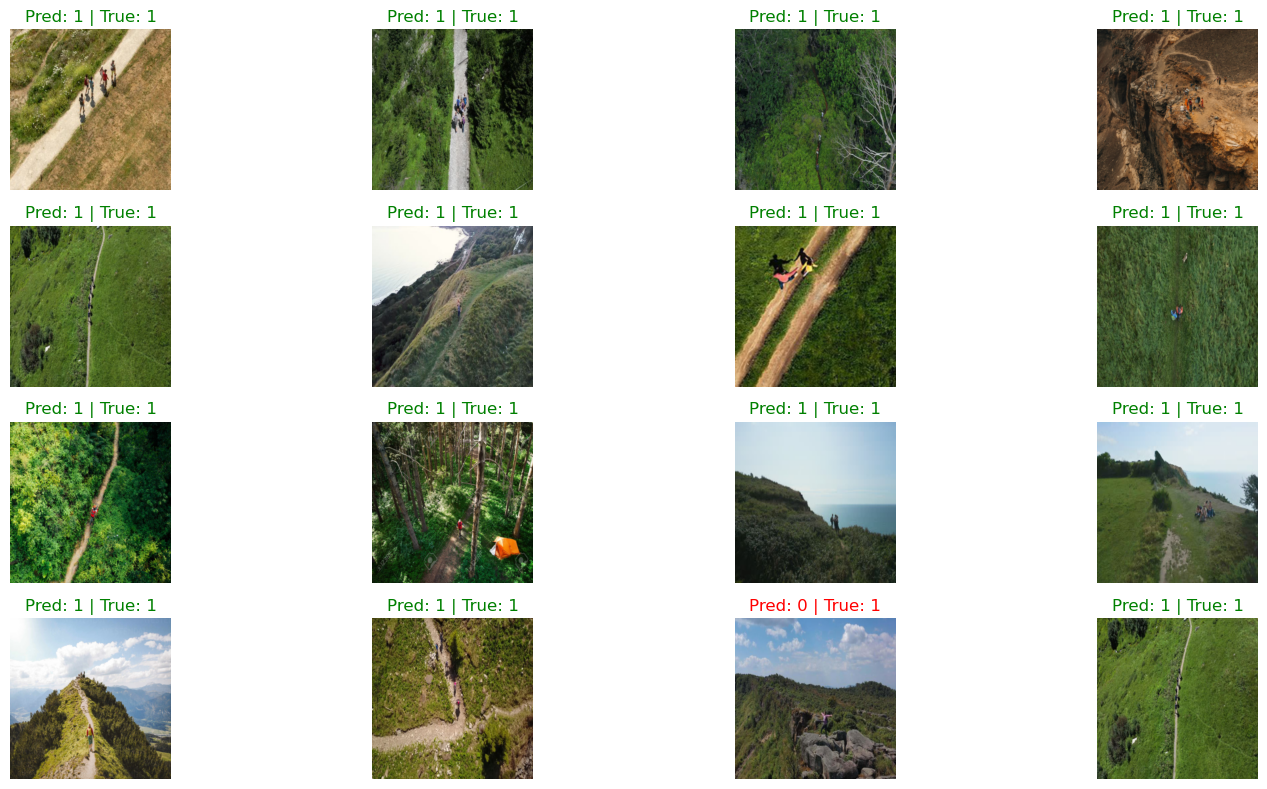

In [40]:
# Create a DataLoader for your extra 'pp' folder
pp_loader = load_folder_as_loader(
    folder_path="pp",          # folder containing your extra images
    transform=eval_transform,  # same eval transform as valid/test
    batch_size=BATCH_SIZE,
    label_value=1              # all images in pp have people
)

# Evaluate numerically on pp set (optional, but useful)
pp_results = evaluate_on_loader(model, pp_loader, device, loader_name="pp")

# Visual check: show some random predictions from pp
show_predictions_grid(model, pp_loader, device, num_images=16)

Extra folder 'no_pp' loaded: X shape = torch.Size([24, 3, 320, 320]), y shape = torch.Size([24])
All labels are set to 0 (has_person).

========== Evaluation on pp set ==========
Avg loss: 0.3862
Accuracy: 91.67% (22/24)

Predicted class counts:
  Pred 0 (no human): 22
  Pred 1 (human):    2

True label counts:
  True 0 (no human): 24
  True 1 (human):    0

Confusion matrix (rows=true, cols=pred):
          Pred 0    Pred 1
True 0 |     22        2
True 1 |      0        0


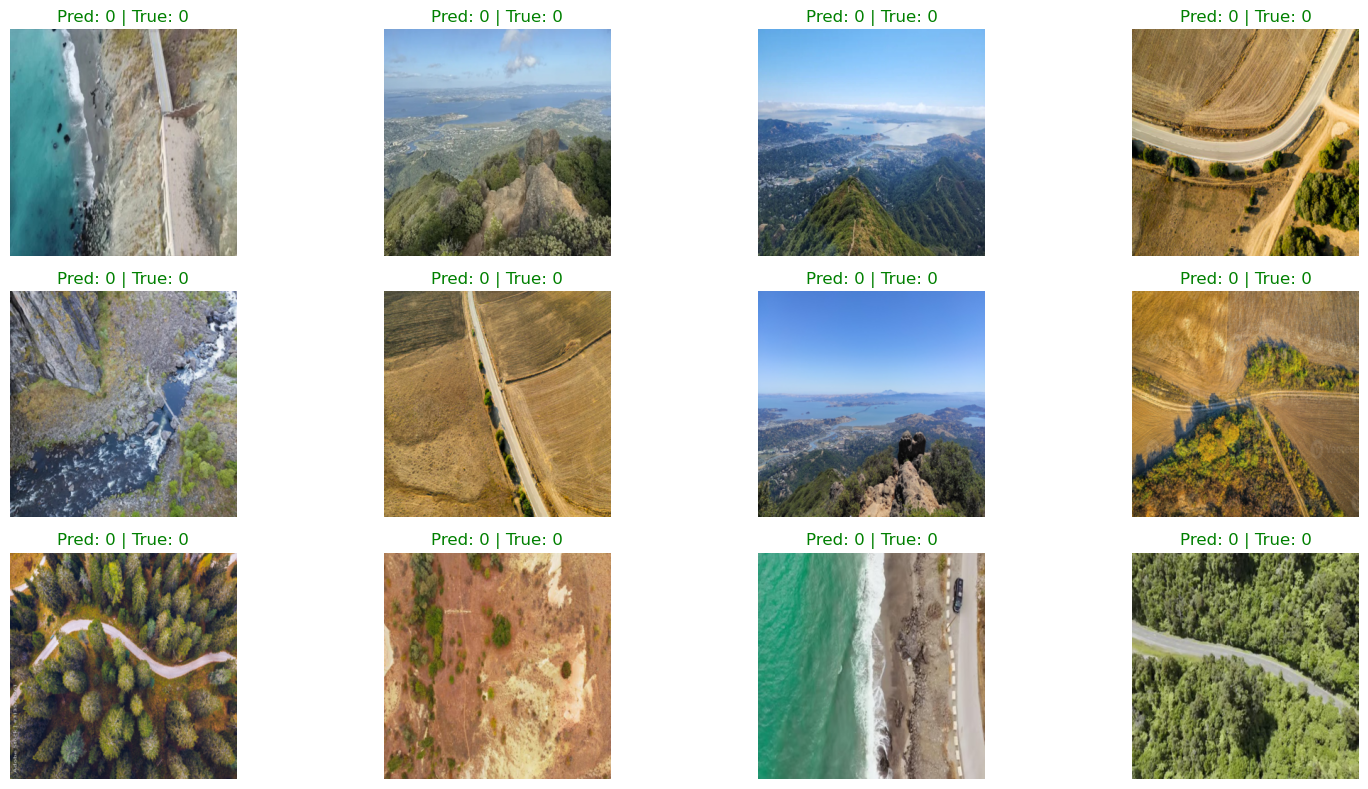

In [41]:
# Create a DataLoader for your extra 'pp' folder
no_pp_loader = load_folder_as_loader(
    folder_path="no_pp",          # folder containing your extra images
    transform=eval_transform,  # same eval transform as valid/test
    batch_size=BATCH_SIZE,
    label_value=0              # all images have no people
)

# Evaluate numerically on pp set (optional, but useful)
no_pp_results = evaluate_on_loader(model, no_pp_loader, device, loader_name="pp")

# Visual check: show some random predictions from pp
show_predictions_grid(model, no_pp_loader, device, num_images=12)
